In [39]:
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [40]:
# Setting display priorities, might cause security issues because of the raw html injection !
from IPython.core.display import display, HTML
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
display(HTML("<style>.container { width:80% !important; }</style>")) # uncomment for security issues
np.set_printoptions(precision=4)
pd.set_option('display.max_columns',50)

In [12]:
# Loading the xgb model from file
xgbmodel = xgb.Booster()
xgbmodel.load_model("xgb.model")


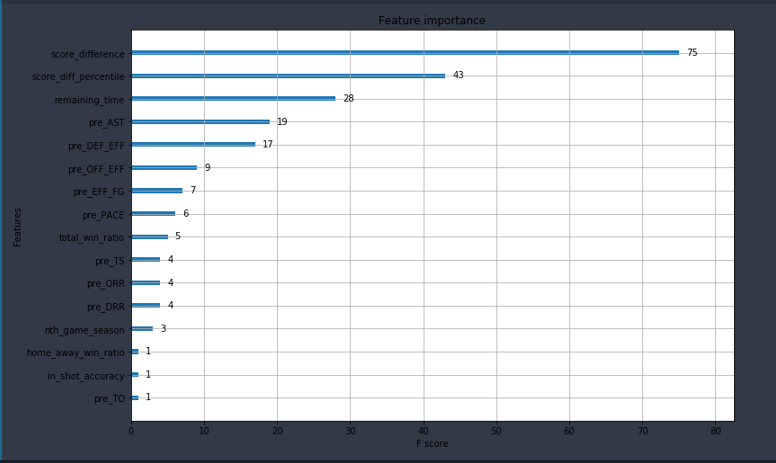

In [14]:
from IPython.display import Image
Image("xgb_plotimportance.PNG")

The final features of the model are 27. For the method to predict we will only use the top features of xgb as shown above. In-game features has to be provided by the user and pre game features will be calculated based on home and away team. We may need to assume values for total_win_ratio, nth_game_season, in_shot_accuracy, home_away_win_ratio and away team.

In [18]:
# Read in the external features
external = pd.read_csv('team_ratings.csv')

def external_ratings(home, away, year):
    return (external[((external['TEAM_ABBR'] == home) & (external['YEAR'] == year))].values[0][3:] - external[((external['TEAM_ABBR'] == away) & (external['YEAR'] == year))].values[0][3:])


All the unknown quantities are replaced by the mean value of the column

In [45]:
strat_sample = pd.read_csv("strat_sample.csv")
strat_sample.drop(labels=['Unnamed: 0'], axis=1, inplace=True)

In [22]:
external_ratings('OKC', 'CLE', 2016)

array([3.9000000000000057, -0.6999999999999993, 1.3000000000000007, 6.0,
       -2.5, 2.700000000000003, 0.0, 0.7000000000000028,
       1.8000000000000114, 0.7000000000000028], dtype=object)

In [83]:
# This function takes in a test record and predicts the output
def predict(home_dict, away_dict,  misc_dict, remaining_time, year):
    pre_PACE, pre_AST, pre_TO, pre_ORR, pre_DRR, pre_EFF_FG, pre_TS, pre_OFF_EFF, pre_DEF_EFF,_ = external_ratings(home_dict['home_team'], away_dict['away_team'], year)
    
    total_win_ratio = strat_sample['total_win_ratio'].mean()
    home_away_win_ratio = strat_sample['home_away_win_ratio'].mean()
    nth_game_season = strat_sample['nth_game_season'].mean()
    
    score_difference = away_dict['away_score'] - home_dict['home_score']
    score_difference_percentile = (away_dict['away_score'] - home_dict['home_score'])/(away_dict['away_score'] +home_dict['home_score'])
    
    home_rank = misc_dict['home_rank']
    away_rank = misc_dict['away_rank']
    
    in_hfouls = misc_dict['in_hfouls']
    in_hsfouls = misc_dict['in_hshfouls']
    in_violations = strat_sample['in_violations'].mean()
    in_rebound  = strat_sample['in_hfouls'].mean()
    in_afouls = strat_sample['in_afouls'].mean()
    in_asfouls = strat_sample['in_ashoot_fouls'].mean()
    in_turnover = strat_sample['in_turnover'].mean()
    in_shot_accuracy = strat_sample['in_shot_accuracy'].mean()
    in_ft_accuracy = strat_sample['in_ft_accuracy'].mean()
    in_momentum = strat_sample['in_momentum'].mean()
    
    columns = ['remaining_time', 'score_difference',
       'score_diff_percentile', 'in_violations', 'in_rebound',
       'in_hfouls', 'in_hshoot_fouls', 'in_afouls', 'in_ashoot_fouls',
       'in_turnover', 'in_shot_accuracy', 'in_ft_accuracy', 'in_momentum',
       'total_win_ratio', 'home_away_win_ratio', 'nth_game_season', 'pre_PACE',
       'pre_AST', 'pre_TO', 'pre_ORR', 'pre_DRR', 'pre_EFF_FG', 'pre_TS',
       'pre_OFF_EFF', 'pre_DEF_EFF', 'home_rank', 'away_rank']
    
    test = np.array([remaining_time, score_difference, score_difference_percentile, in_violations, in_rebound, in_hfouls, in_hsfouls, in_afouls, in_asfouls,
                    in_turnover, in_shot_accuracy, in_ft_accuracy, in_momentum, total_win_ratio, home_away_win_ratio, nth_game_season, pre_PACE, pre_AST,
                    pre_TO, pre_ORR, pre_DRR, pre_EFF_FG, pre_TS, pre_OFF_EFF, pre_DEF_EFF, home_rank, away_rank]).transpose()
                    
    test.shape = (1,27)
    dtest = xgb.DMatrix(test, feature_names=strat_sample.columns)
    print("Probability of home team winning {}".format(xgbmodel.predict(dtest)))
    
    
    

Question 3 : part 1 
------------------

In [146]:
home_dict = {"home_score":105, "home_team":"OKC"}
away_dict = {"away_score":106, "away_team":"CLE"}
misc_dict = {"in_hfouls":1,"in_hshfouls":1,"home_rank":150,"away_rank":150}
predict(home_dict, away_dict, misc_dict, 529, 2016)
predict(home_dict, away_dict, misc_dict, 529, 2015)

Probability of home team winning [ 0.5238]
Probability of home team winning [ 0.3553]
